In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
sys.path.append("/home/jaime/Desktop/")
import file_management
from collections import Counter
#import scipy as sp 
from scipy import signal as sp

current_folder = os.getcwd()
current_folder = '/home/jaime/Desktop/hippocampus/noviembre/v2ca1_optimization/'
folder = os.path.join(current_folder, "folder28")
n = 21
runtime = 4000
dt = 0.1

# Functions

In [2]:
def get_spiking_phase_distribution(xlist, ylist, phase_reference, simulation_time=4000, nbins=20, dt=0.1): 
    time = np.arange(0,simulation_time-dt,dt)
    nsims = len(xlist) 

    starting_cycles = np.where( np.abs( np.diff( phase_reference )) > 1.9*np.pi)[0]
    ncycles =  len(starting_cycles)-1
    nspikes = np.zeros((nsims*ncycles, nbins))
    nspikes_std = np.zeros((nsims*ncycles, nbins))

    for k, (x, y) in enumerate(zip(xlist, ylist)): 

        for ii in range(ncycles):
            n1,n2 = starting_cycles[ii]+1, starting_cycles[ii+1]
            t1,t2 = time[n1],time[n2]
            phi1, phi2 = phase_reference[n1], phase_reference[n2]

            time_aux = np.linspace(t1,t2,nbins+1)
            phi_aux  = np.linspace(phi1,phi2, nbins+1)
            dphi = np.diff(phi_aux[:2])
            phi_seq = phi_aux[:-1]+dphi/2.0

            for jj in range(len(time_aux[:-1])):
                tj1,tj2 = time_aux[jj],time_aux[jj+1]
                w = np.logical_and(x >= tj1, x < tj2)
                nspikes[(k+1)*ii,jj] = len( x[w] )

    spikes_mean = np.mean(nspikes, axis=0)
    spikes_std  = np.std(nspikes, axis=0)
    spikes_sem  = np.std(nspikes, axis=0)/np.sqrt(ncycles*nsims)

    spike_phase_peak = phi_seq[np.argmax(spikes_mean)]*180/np.pi

    phiseq = np.array( phi_seq.tolist() + (phi_seq+2*np.pi).tolist() )*180/np.pi
    spike_phase_mean = np.array( spikes_mean.tolist()*2)
    spike_phase_std  = np.array( spikes_std.tolist()*2 )
    spike_phase_sem  = np.array( spikes_sem.tolist()*2 )
    return phiseq, spike_phase_mean, spike_phase_std, spike_phase_sem, spike_phase_peak

def get_nfft(m):
    nfft = 2
    k = 0
    while m > nfft:
        k+=1
        nfft = 2**k
    return nfft

def bandpass_filter(xs, norder, f_range, fs=1e4): 
    sos = sp.butter(N=norder, Wn=f_range, btype="bandpass", fs=fs, output="sos")
    return sp.sosfilt(sos,xs)

def get_mean_activity_per_cycle(xlist, ylist, theta_cycle=125):
    '''
    xlist: different realizations list, spikes
    ylist: different realizations list, neuron number
    '''
    n = 8
    initial_time = 50 + n*theta_cycle
    
    xaux = np.concatenate(xlist)
    final_time = xaux.max()-np.mod(xaux.max(),theta_cycle)
    
    nspikes = []
    active_neurons = []
    active_same_neurons = []
    for x, y in zip(xlist, ylist):
        t1, t2 = initial_time, initial_time+theta_cycle
        
        while t2<=final_time:
            w = np.logical_and(x>=t1, x<t2)
            nspikes.append( len(x[w]) ) 
            active_neurons.append( len(np.unique(y[w])) )
            
            yaux = Counter(y[w]) 
            yaux = np.array(list(yaux.values()))
            active_same_neurons.append( len(yaux[np.where(yaux>1)]) )
            
            t1+=theta_cycle
            t2+=theta_cycle
    
    n = len(nspikes)
    nspikes_std = np.round( np.std(nspikes)/np.sqrt(n),2)
    nspikes_mean = np.round( np.mean(nspikes), 2)
    active_neurons_std = np.round( np.std(active_neurons)/np.sqrt(n), 2)
    active_neurons_mean = np.round( np.mean(active_neurons), 2)
    active_same_neurons_std = np.round( np.std(active_same_neurons)/np.sqrt(n), 2)
    active_same_neurons_mean = np.round( np.mean(active_same_neurons), 2) 
    
    return nspikes_mean, nspikes_std, active_neurons_mean, active_neurons_std, active_same_neurons_mean, active_same_neurons_std


def get_voltage_diff_per_cycle(t,x):
    theta_cycle = 125
    initial_time = 50 + 5*theta_cycle
    t1, t2 = initial_time, initial_time+theta_cycle 
    final_time = t[-1]-np.mod(t[-1], theta_cycle)
    
    vdiff = []
    vmin, vmax = [],[]
    while t2<=final_time:
        w = np.logical_and(t>=t1, t<t2)

        vmin.append( np.min( x[w] ) ) 
        vmax.append( np.max( x[w] ) )

        vdiff.append( vmax[-1]-vmin[-1] )    

        t1+=theta_cycle
        t2+=theta_cycle

    vdiff_mean = np.mean( vdiff )
    vdiff_sem  = np.std( vdiff )/np.sqrt(len(vdiff))
    vmin_mean  = np.mean(vmin)                                     
    vmin_sem   = np.std(vmin)/np.sqrt(len(vdiff))
    vmax_mean  = np.mean(vmax)                                     
    vmax_sem   = np.std(vmax)/np.sqrt(len(vdiff))
    return vmin_mean, vmin_sem, vmax_mean, vmax_sem, vdiff_mean, vdiff_sem
    

# External inputs 

In [3]:
external_inputs_times = { }
external_inputs_times["ec2_180"]    = np.round( np.arange(50+125/2.0, 8000, 125), 1)
external_inputs_times["ec3_360"]    = np.round( np.arange(50, 8000, 125), 1 )
external_inputs_times["sep_180"]    = np.round( np.arange(50+125/2.0, 8000, 125), 1)
external_inputs_times["sep_360"]    = np.round( np.arange(50, 8000, 125), 1 ) 
external_inputs_times["dg_regular"] = np.round( np.arange(50+0.375*125, 8000, 125), 1)
external_inputs_times["dg_burst"]   = np.round( np.arange(50+0.125*125, 8000, 125), 1)

external_inputs_folder = "/home/jaime/Desktop/hippocampus/external_inputs_python/10"
external_inputs_pyr_ca3 = file_management.load_lzma( os.path.join( external_inputs_folder, "external_inputs_pyr_ca3_0_0.lzma"))
external_inputs_times["pyr_ca3"] = np.round( np.arange(50+80/360*125, 8000, 125 ), 1)
theoretical_center_of_ca1_pyr = np.round( np.arange(50+200/360*125, 8000, 125 ), 1)

external_inputs_folder = "/home/jaime/Desktop/hippocampus/external_inputs_python/"
external_inputs = {}
external_inputs["ec3_360"] =file_management.load_lzma( os.path.join( external_inputs_folder, "external_inputs_ec3_360_0.lzma"))


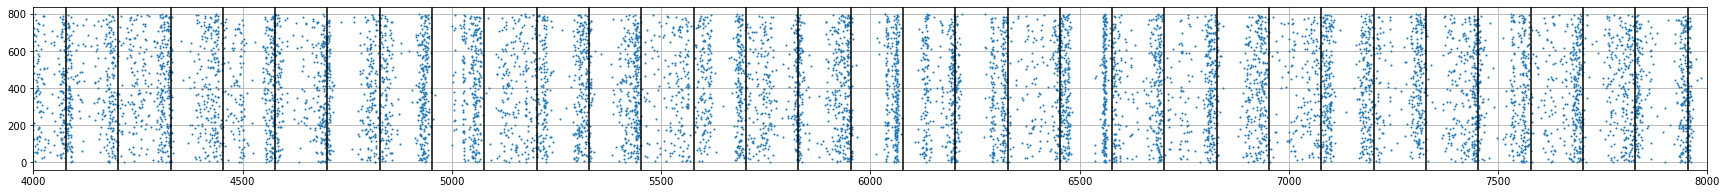

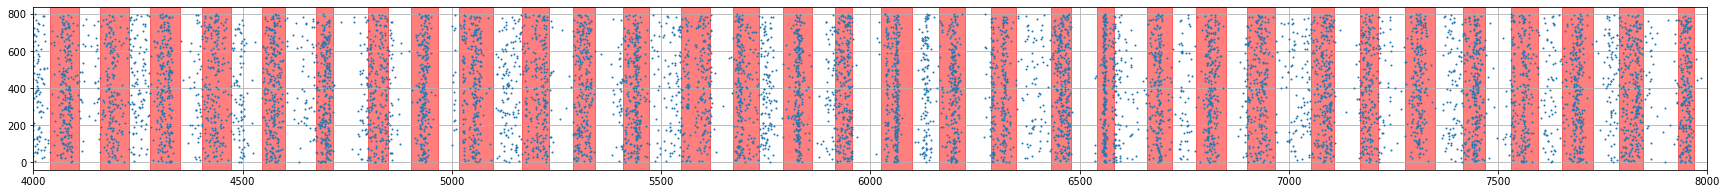

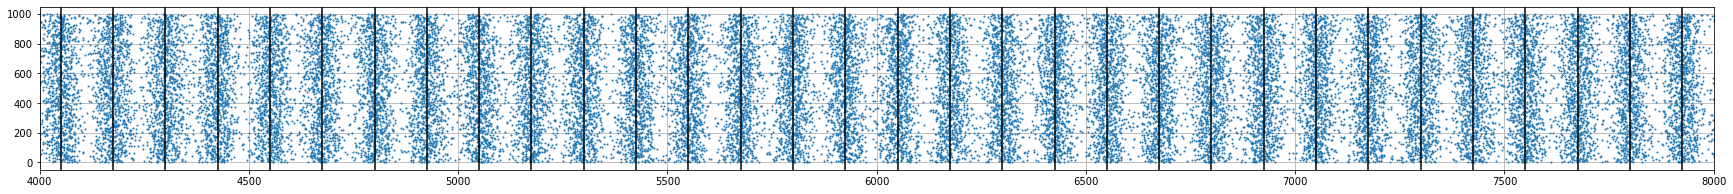

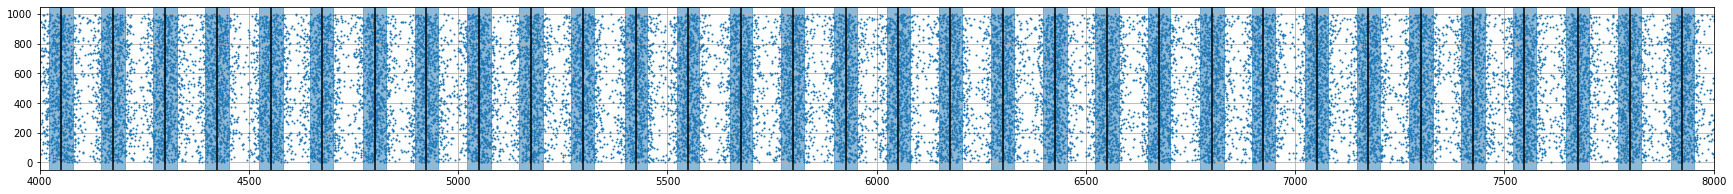

In [4]:
plt.figure(figsize=(30,3))
plt.plot( external_inputs_pyr_ca3["tvec"], external_inputs_pyr_ca3["idvec"],'o', markersize=1)
for h in external_inputs_times["pyr_ca3"]: 
    plt.axvline(h,color="black")
plt.xlim([4000,8000])
plt.grid(True) 

# pyramidal ca3
time_pyr_ca3 = external_inputs_pyr_ca3["tvec"]
id_pyr_ca3 = external_inputs_pyr_ca3["idvec"]

hpyr_mean = np.zeros( len(external_inputs_times["pyr_ca3"]) )
hpyr_std  = np.zeros( len(external_inputs_times["pyr_ca3"]) )
for i, h in enumerate( external_inputs_times["pyr_ca3"]): 
    w = (time_pyr_ca3 >= h-75) & ( time_pyr_ca3 < h+75)
    hpyr_mean[i] = np.median(time_pyr_ca3[w]) 
    hpyr_std[i]  = np.std(time_pyr_ca3[w]) 

# ec3 360 external inputs 
time_ec3_360 = external_inputs["ec3_360"]["tvec"]
id_ec3_360 = external_inputs["ec3_360"]["idvec"]
hec3_mean = np.zeros( len( external_inputs_times["ec3_360"]) )
hec3_std  = np.zeros( len( external_inputs_times["ec3_360"]) )

for i, h in enumerate( external_inputs_times["ec3_360"]): 
    w = (time_ec3_360 >= h-75) & ( time_ec3_360 < h+75)
    hec3_mean[i] = np.median(time_ec3_360[w]) 
    hec3_std[i]  = np.std(time_ec3_360[w]) 
    
plt.figure(figsize=(30,3))
plt.plot( external_inputs_pyr_ca3["tvec"], external_inputs_pyr_ca3["idvec"],'o', markersize=1) 
for h, dh in zip( hpyr_mean, hpyr_std): 
    plt.axvspan(h-dh, h+dh, alpha=0.5, color='red')
plt.xlim([4000,8000])
plt.grid(True) 

plt.figure(figsize=(30,3))
plt.plot( external_inputs["ec3_360"]["tvec"], external_inputs["ec3_360"]["idvec"],'o', markersize=1)
for h in external_inputs_times["ec3_360"]: 
    plt.axvline(h,color="black")
plt.xlim([4000,8000])
plt.grid(True)

plt.figure(figsize=(30,3))
plt.plot( external_inputs["ec3_360"]["tvec"], external_inputs["ec3_360"]["idvec"],'o', markersize=1)
for h, dh in zip(hec3_mean, hec3_std): 
    plt.axvspan(h-dh, h+dh, alpha=0.5, color='tab:blue')
    plt.axvline(h,color="black")

plt.xlim([4000,8000])
plt.grid(True)

# 10 realizations, 1 external inputs ##

In [5]:
ntrials = 1
nexternal = 1 

extra_label_title = "only_ca1_"
cells = ["pyr","bas","olm", "cck"]
spikes    = dict.fromkeys(cells)
id_spikes = dict.fromkeys(cells)

volt = dict.fromkeys(cells) 
volt_mean = dict.fromkeys(cells) 
volt_sem  = dict.fromkeys(cells)
for cell in cells: 
    spikes[cell]    = [ [] for i in range(n)] # dict.fromkeys(["tvec","idvec"]) por ahora esto no interesa
    id_spikes[cell] = [ [] for i in range(n)] # dict.fromkeys(["tvec","idvec"]) por ahora esto no interesa
    volt[cell]      = [ [] for i in range(n)]
    volt_mean[cell] = [ [] for i in range(n)]
    volt_sem[cell]  = [ [] for i in range(n)]
    
for k in range(ntrials):
    for i in range(n): 
        argvs = f"{k}_{i}.lzma"
    
        title = "spikes_"+extra_label_title+argvs
        data3 = file_management.load_lzma( os.path.join(folder, title) )
        for cell in cells: 
            spikes[cell][i].append( data3["ca1"][cell]["tvec"] )
            id_spikes[cell][i].append( data3["ca1"][cell]["idvec"] )

print("Spikes loaded")

for i in range(n): 
    for k in range(ntrials):
        argvs = f"{k}_{i}.lzma"
        try:
            title = "volt_"+extra_label_title+argvs
            data3 = file_management.load_lzma( os.path.join(folder, title) )
            for cell in cells: 
                volt[cell][i].append( data3["ca1"][cell][0]) # voltage mean of the population 
                #if cell == "pyr":
                #    print( data3["ca1"]["pyr"])
        except:
            print(i, k, "Ando por aqui")
            continue

for cell in cells: 
    for i in range(n):
        volt_mean[cell][i] = np.mean(volt[cell][i],axis=0)
        volt_sem[cell][i] = np.std( volt[cell][i], axis=0)/np.sqrt(ntrials)
print("Membrane potential loaded")

nn = len( volt_mean[cell][i] )
time = np.linspace(0, runtime, len(volt_mean["cck"][0]))

Spikes loaded
Membrane potential loaded


In [6]:
runtime

4000

/home/jaime/anaconda2/envs/prueba_neuron/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jaime/anaconda2/envs/prueba_neuron/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jaime/anaconda2/envs/prueba_neuron/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaime/anaconda2/envs/prueba_neuron/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jaime/anaconda2/envs/prueba_neuron/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

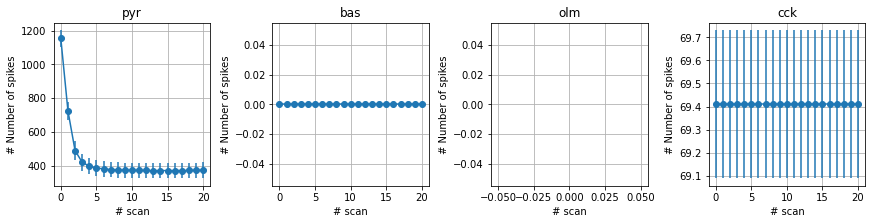

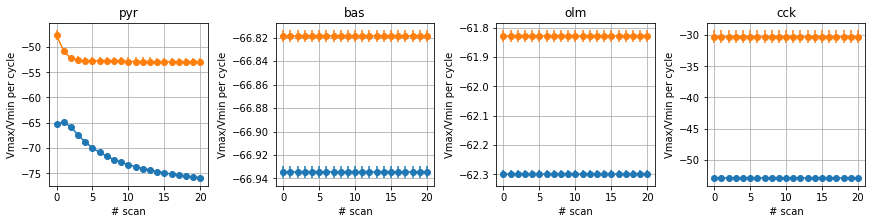

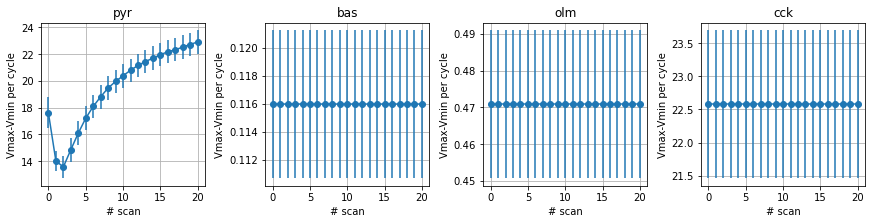

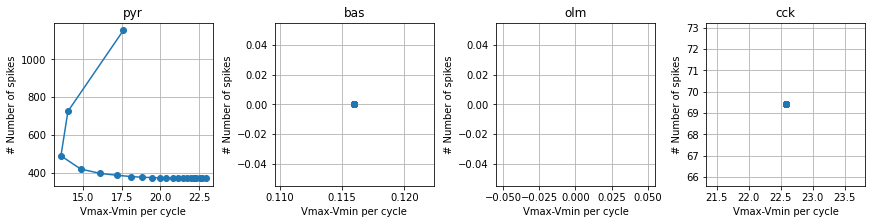

In [7]:
nspikes = dict.fromkeys(cells)
active_neurons = dict.fromkeys(cells)
active_same_neurons = dict.fromkeys(cells)

for cell in cells: 
    nspikes[cell] = {"mean": np.zeros(n), "std": np.zeros(n)}
    active_neurons[cell] = {"mean": np.zeros(n), "std": np.zeros(n)}
    active_same_neurons[cell] = {"mean": np.zeros(n), "std": np.zeros(n)} 
    
vdiff_mean = dict.fromkeys(cells)
vdiff_sem  = dict.fromkeys(cells)
vmin_mean  = dict.fromkeys(cells)
vmin_sem   = dict.fromkeys(cells)
vmax_mean  = dict.fromkeys(cells)
vmax_sem   = dict.fromkeys(cells)
for cell in cells: 
    vdiff_mean[cell] = np.ones(n)*np.nan 
    vdiff_sem[cell]  = np.ones(n)*np.nan  
    vmin_mean[cell]  = np.ones(n)*np.nan  
    vmin_sem[cell]   = np.ones(n)*np.nan  
    vmax_mean[cell]  = np.ones(n)*np.nan  
    vmax_sem [cell]  = np.ones(n)*np.nan 
    
for i in range(n):
    #try:
    for cell in cells: 
        xlist = spikes[cell][i]
        ylist = id_spikes[cell][i]
        if len( np.concatenate(xlist))>0:
            nspikes[cell]["mean"][i], nspikes[cell]["std"][i], active_neurons[cell]["mean"][i], active_neurons[cell]["std"][i], active_same_neurons[cell]["mean"][i], active_same_neurons[cell]["std"][i] = get_mean_activity_per_cycle(xlist, ylist, theta_cycle=125)

        vmin_mean[cell][i], vmin_sem[cell][i], vmax_mean[cell][i], vmax_sem[cell][i], vdiff_mean[cell][i], vdiff_sem[cell][i] = get_voltage_diff_per_cycle(time, volt_mean[cell][i])
    #except:
    #print(i,'Algo ha ido mal')
    #continue

mosaic_list = [cells]
fig, ax = plt.subplot_mosaic(mosaic_list, constrained_layout=True, figsize=(12,3))
for cell in cells:
    ax[cell].errorbar(x = np.arange(n), y=nspikes[cell]["mean"], yerr=nspikes[cell]["std"],marker='o') 
    ax[cell].grid(True)
    ax[cell].set_xlabel('# scan')
    ax[cell].set_ylabel('# Number of spikes')
    ax[cell].set_title(cell)

fig, ax = plt.subplot_mosaic(mosaic_list, constrained_layout=True, figsize=(12,3))
for cell in cells:
    ax[cell].errorbar(x = np.arange(n), y=vmin_mean[cell], yerr=vmin_sem[cell],marker='o') 
    ax[cell].errorbar(x = np.arange(n), y=vmax_mean[cell], yerr=vmax_sem[cell],marker='o') 
    ax[cell].grid(True)
    ax[cell].set_xlabel('# scan')
    ax[cell].set_ylabel('Vmax/Vmin per cycle')
    ax[cell].set_title(cell)
    
fig, ax = plt.subplot_mosaic(mosaic_list, constrained_layout=True, figsize=(12,3))
for cell in cells:
    ax[cell].errorbar(x = np.arange(n), y=vdiff_mean[cell], yerr=vdiff_sem[cell],marker='o') 
    ax[cell].grid(True)
    ax[cell].set_xlabel('# scan')
    ax[cell].set_ylabel('Vmax-Vmin per cycle')
    ax[cell].set_title(cell)
    
fig, ax = plt.subplot_mosaic(mosaic_list, constrained_layout=True, figsize=(12,3))
for cell in cells:
    ax[cell].plot(vdiff_mean[cell], nspikes[cell]["mean"],'o-') 
    ax[cell].grid(True)
    ax[cell].set_xlabel('Vmax-Vmin per cycle')
    ax[cell].set_ylabel('# Number of spikes')
    ax[cell].set_title(cell)

<ipython-input-8-0c96ee626f33>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30,4))


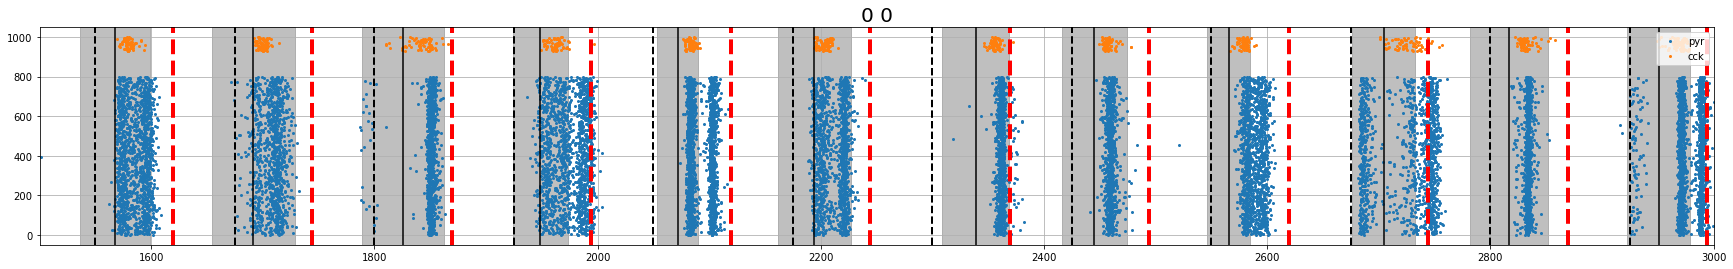

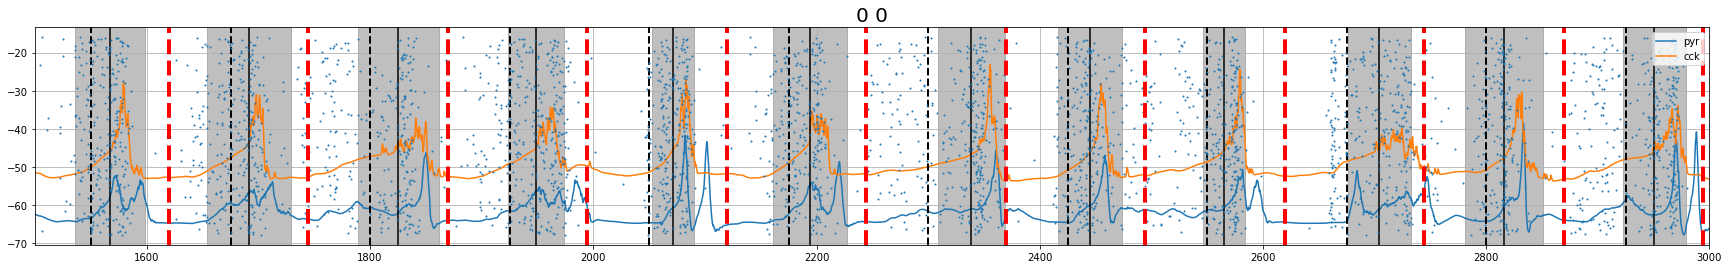

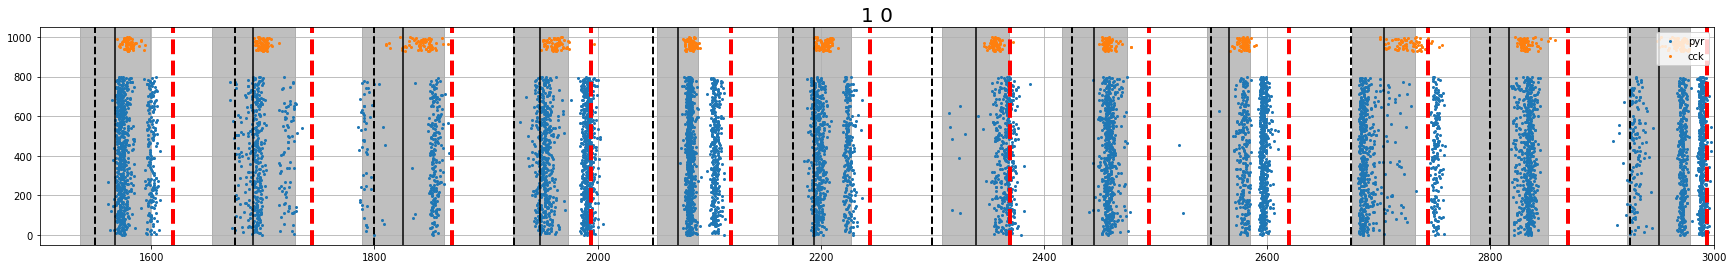

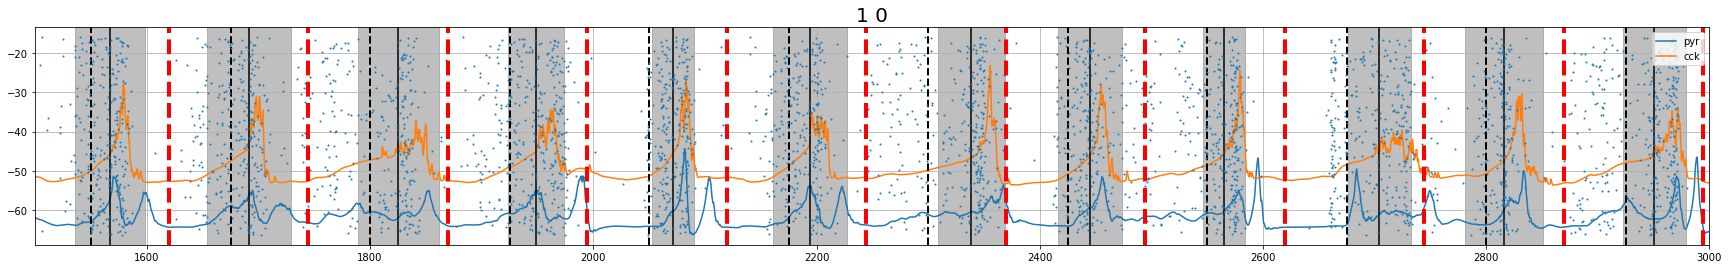

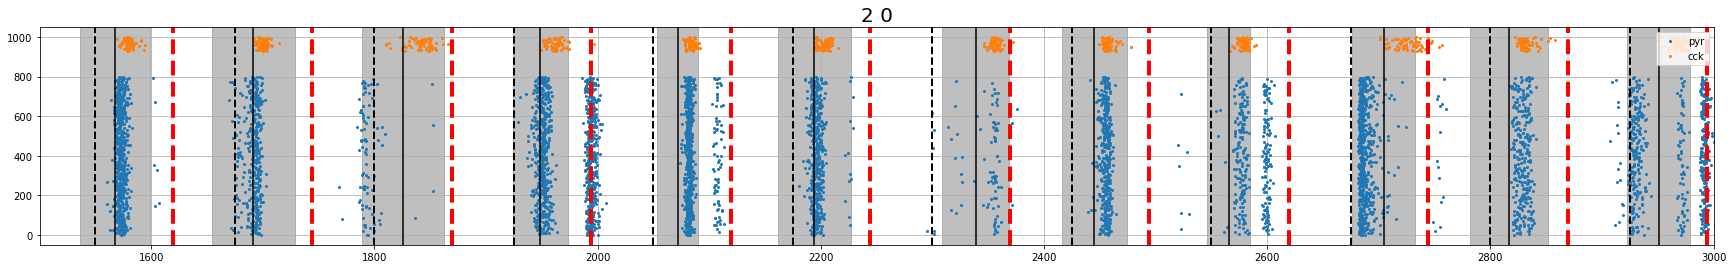

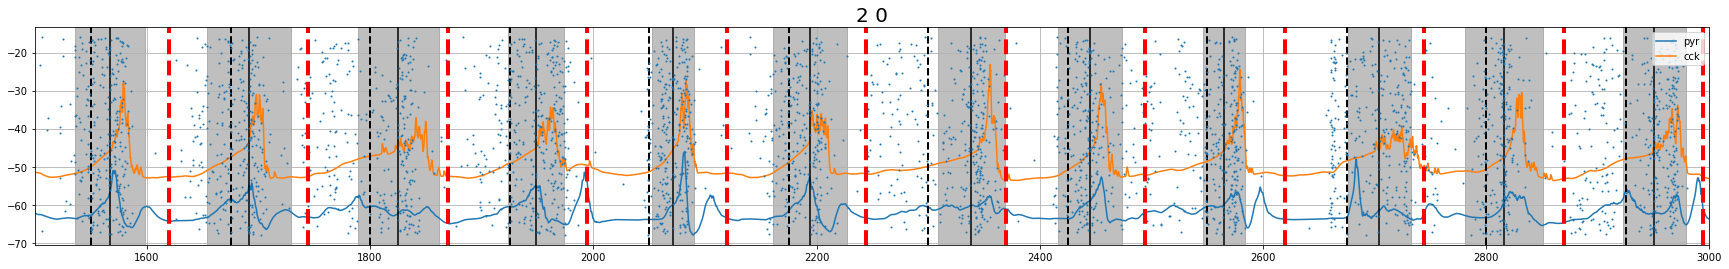

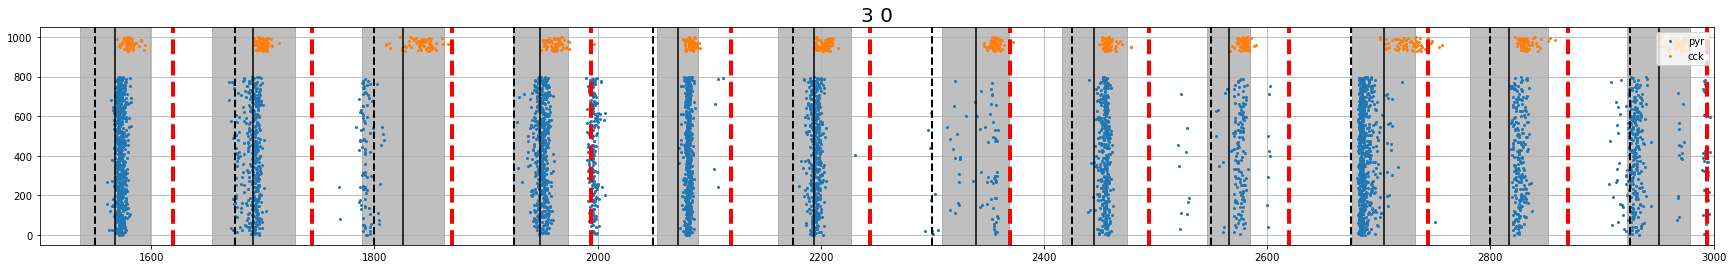

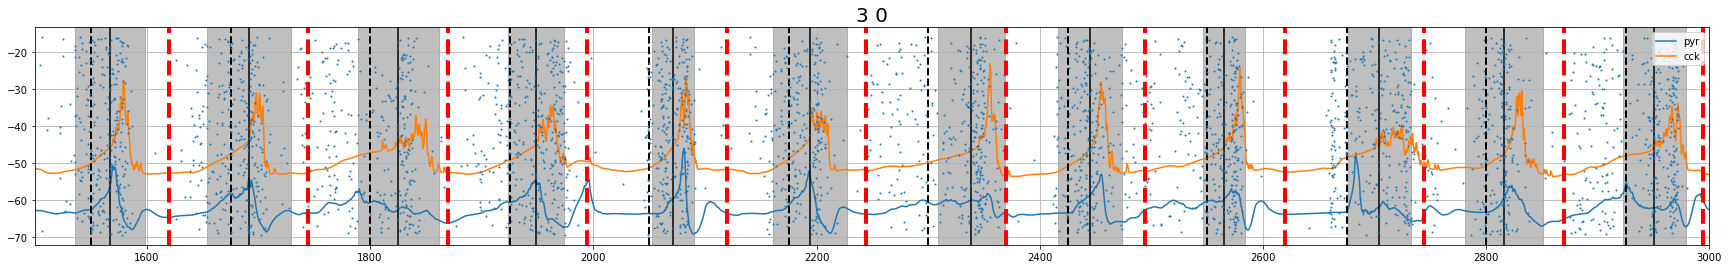

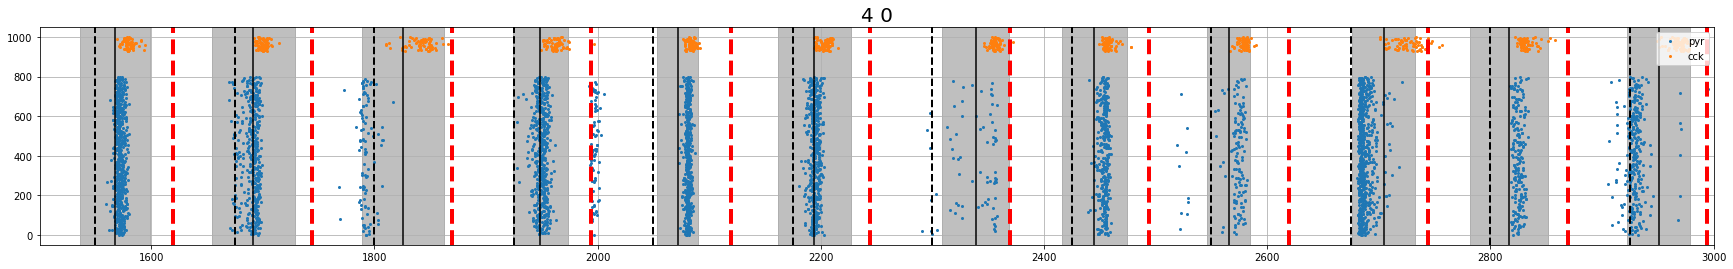

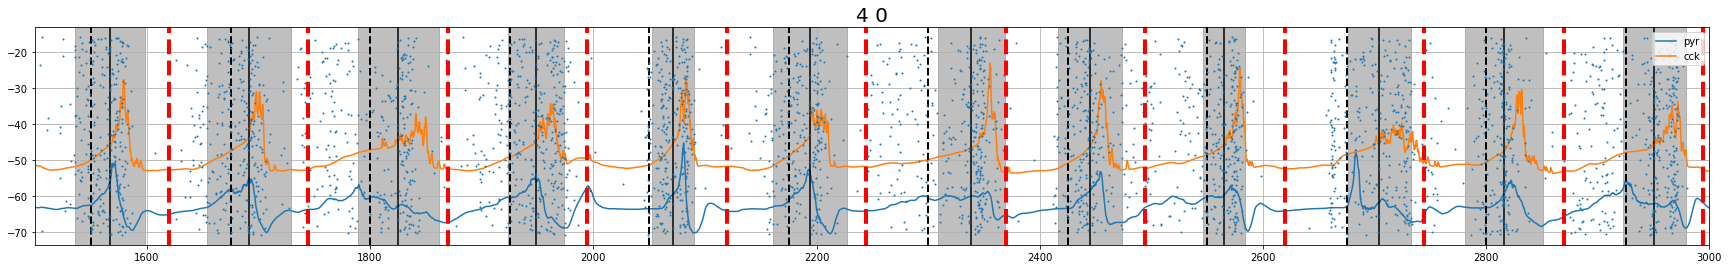

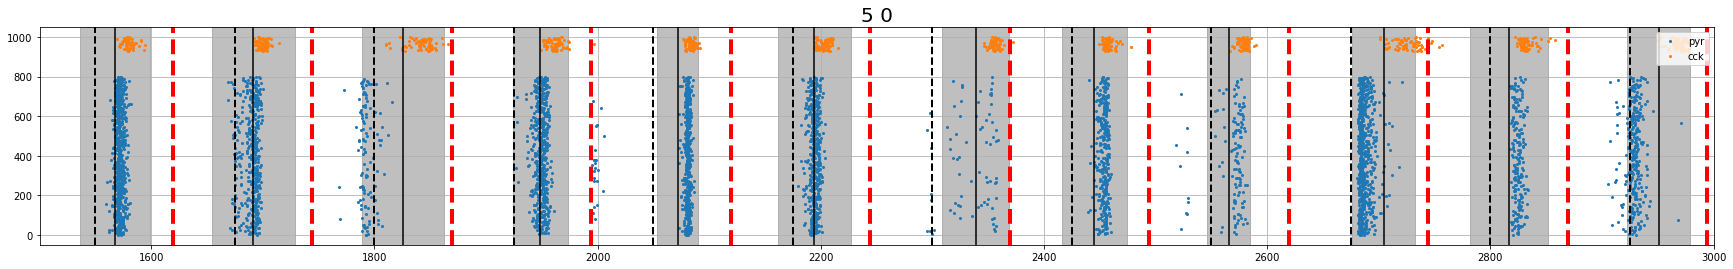

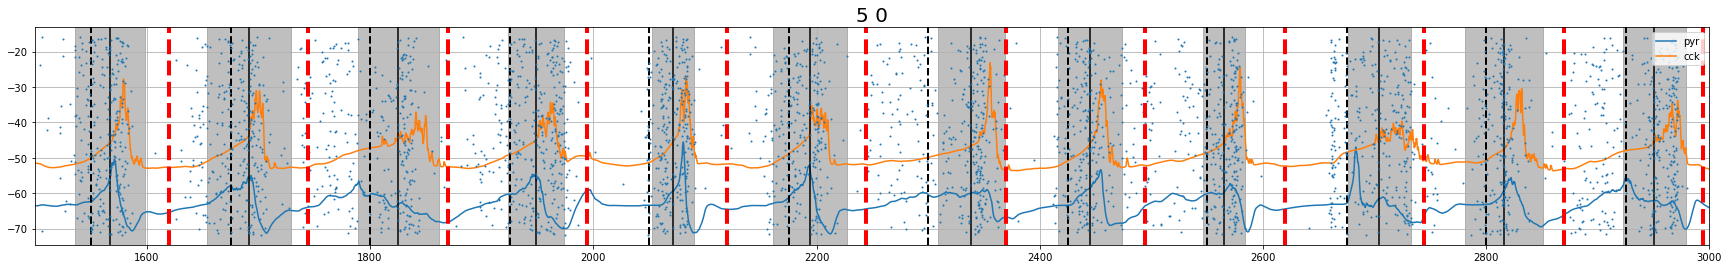

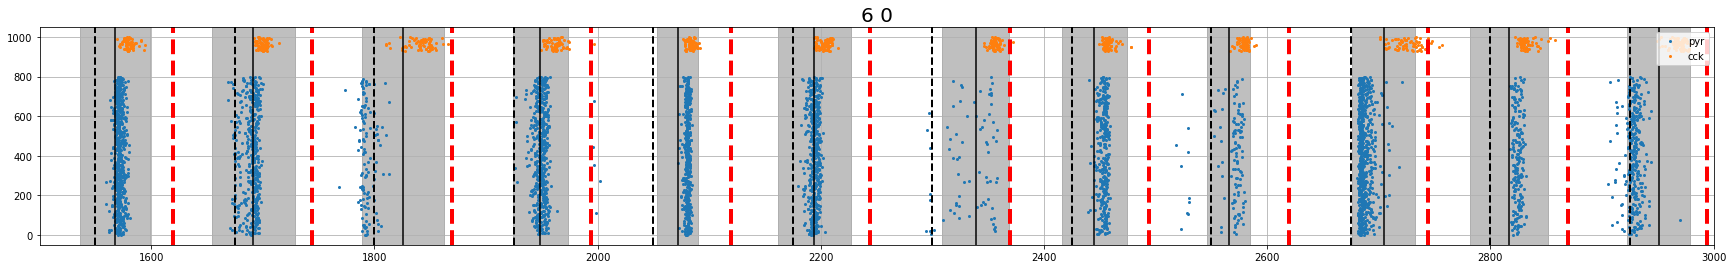

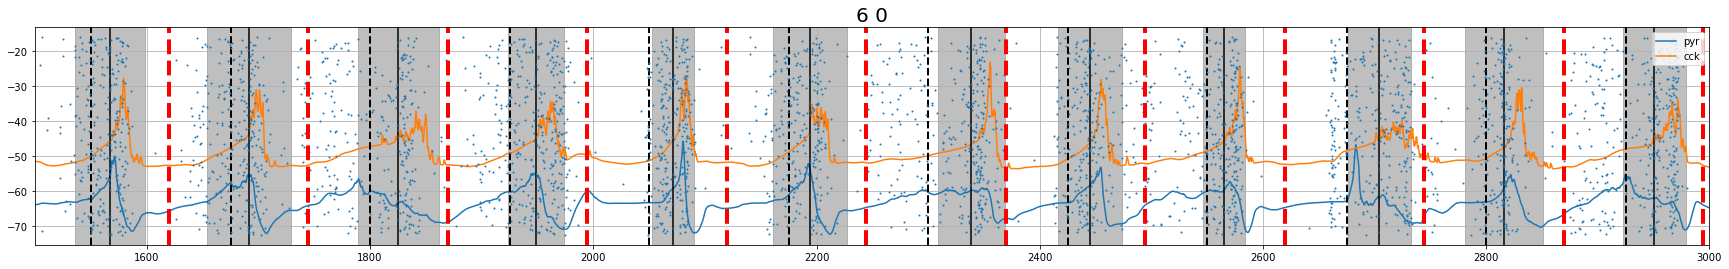

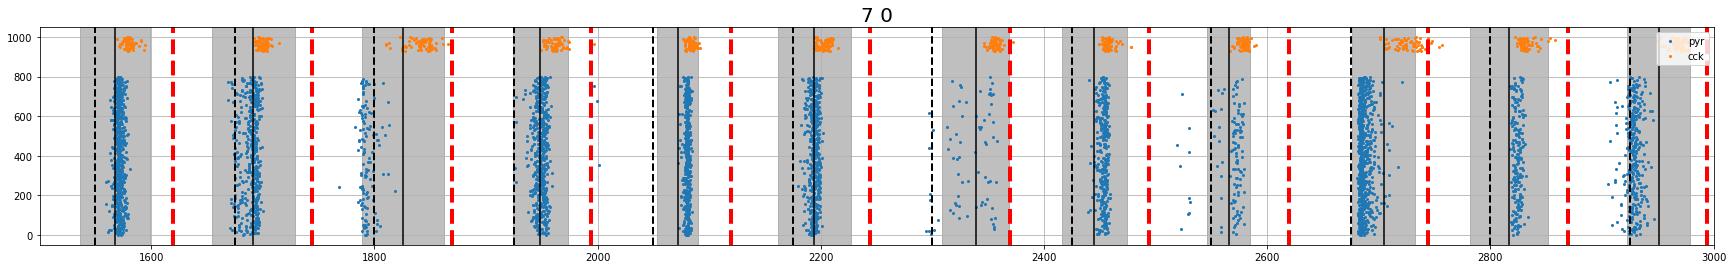

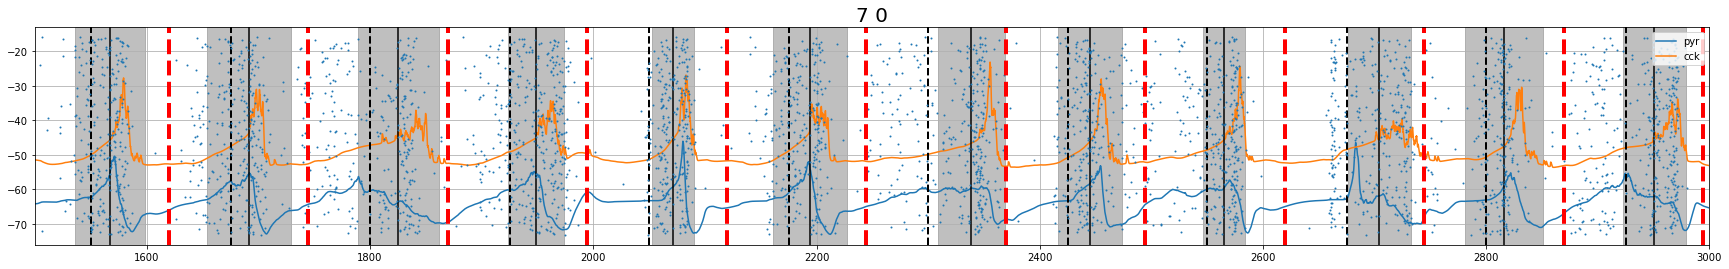

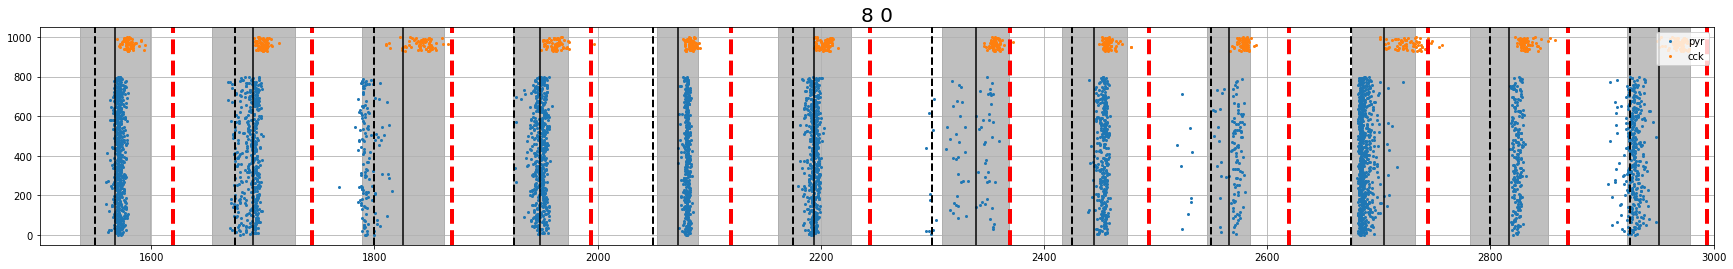

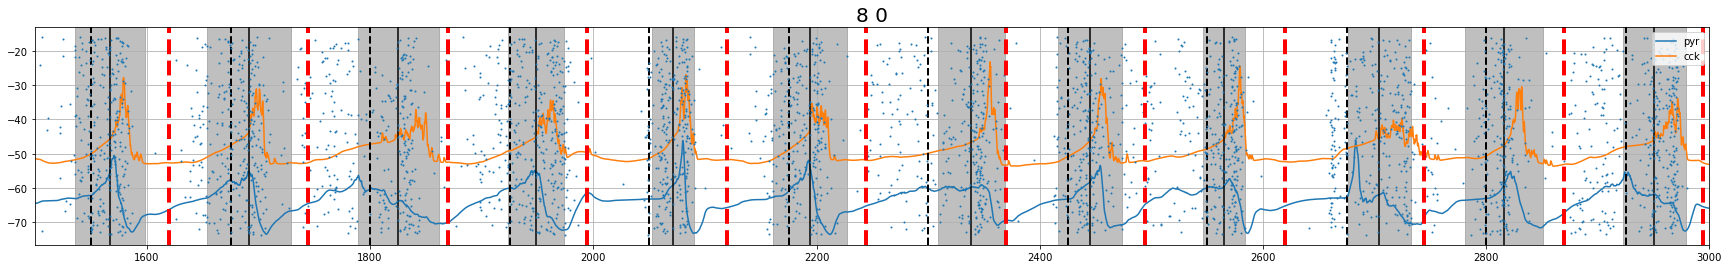

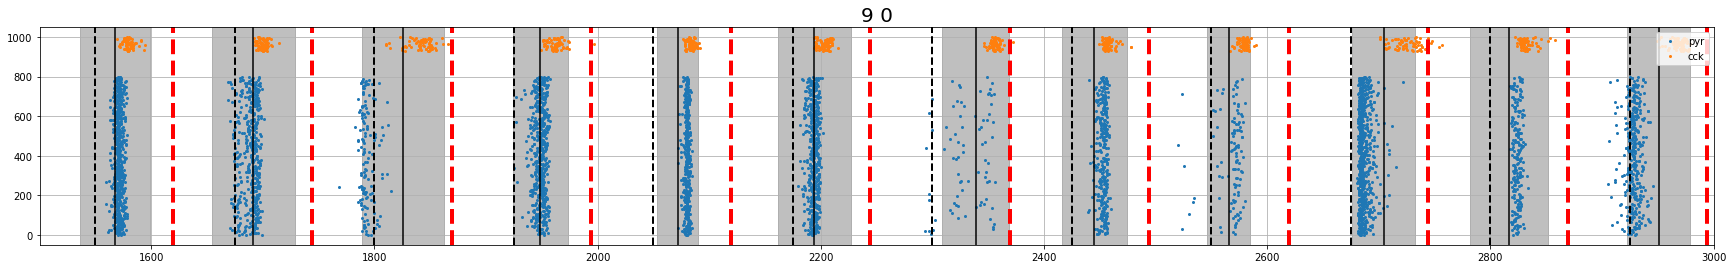

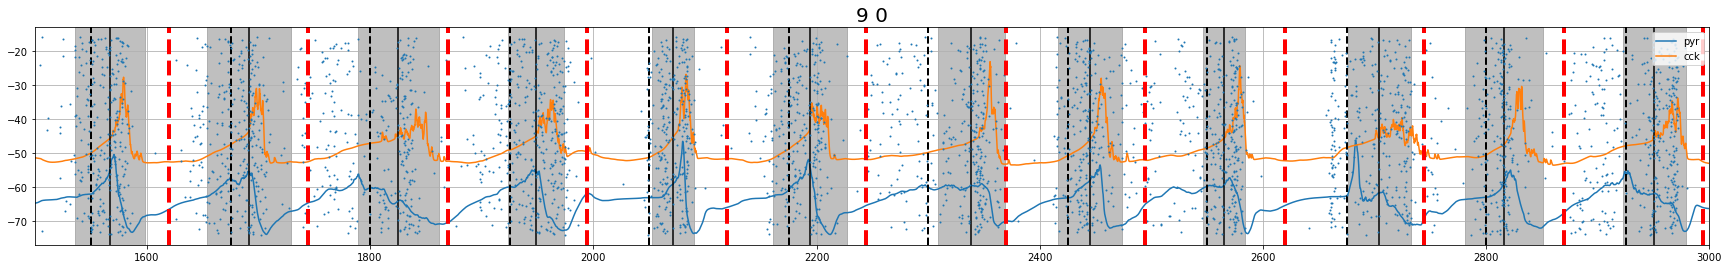

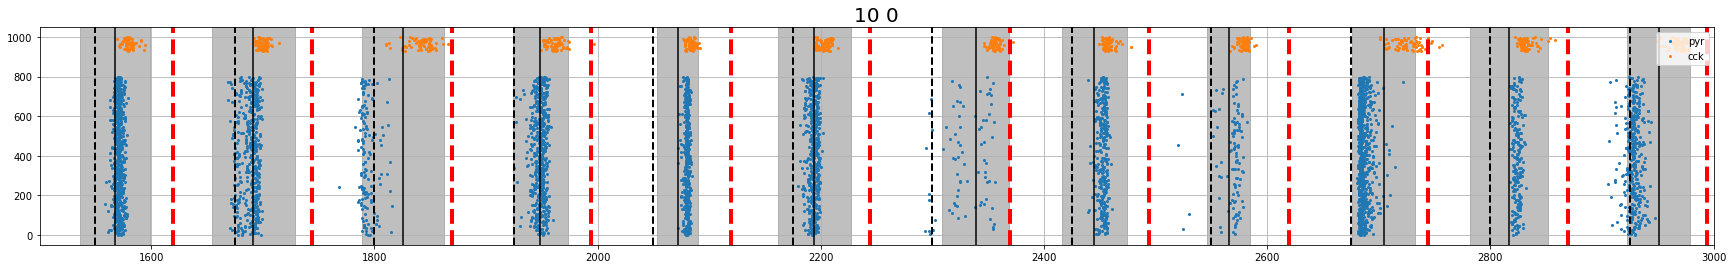

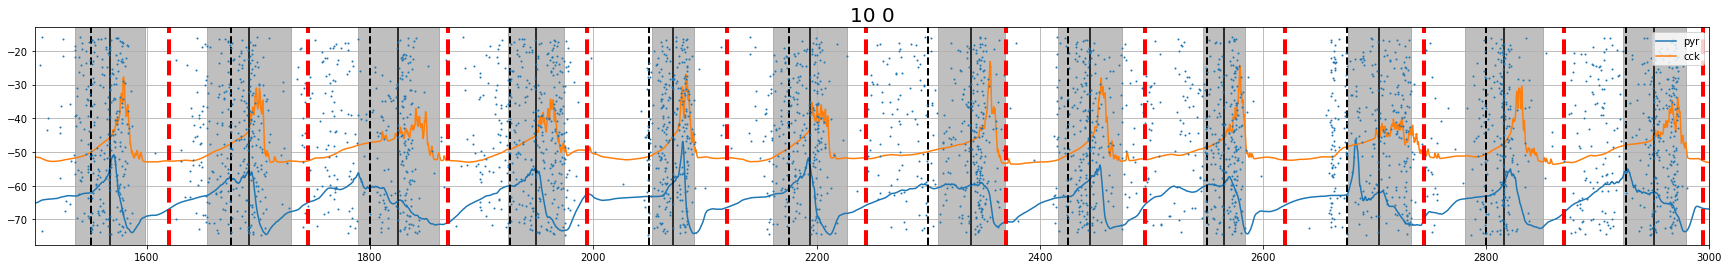

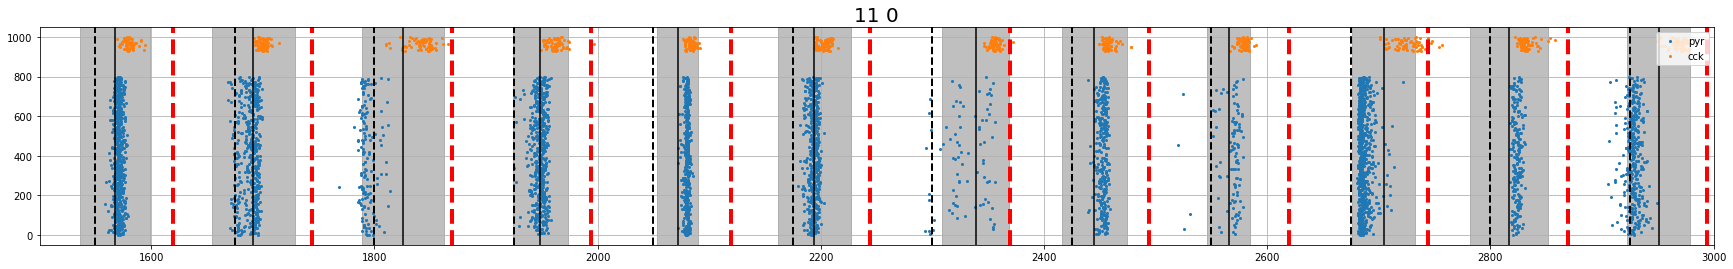

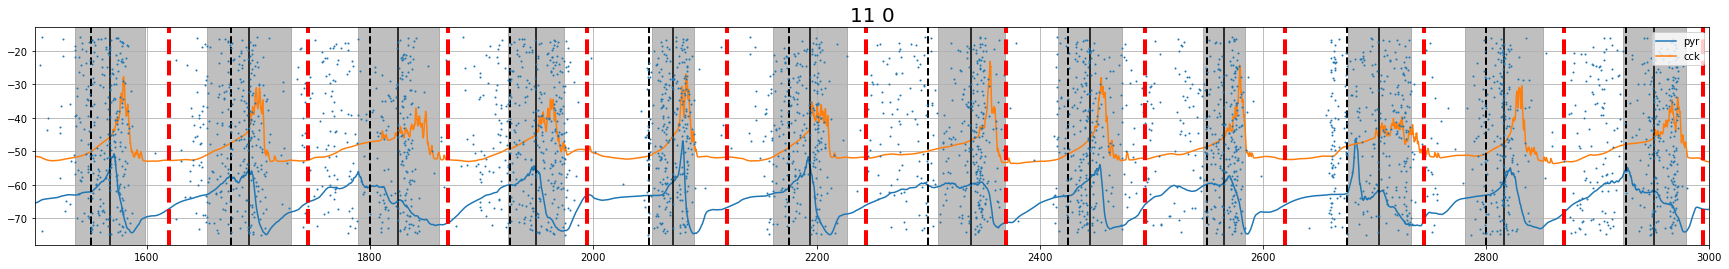

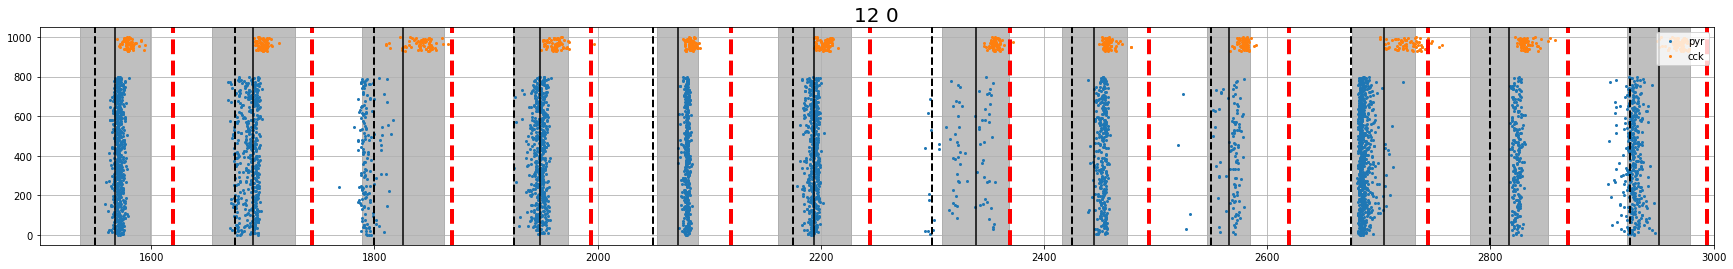

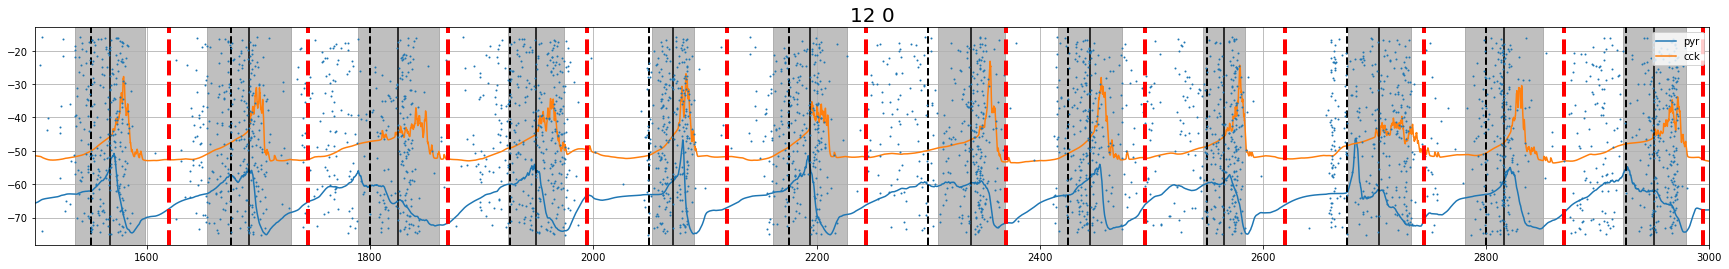

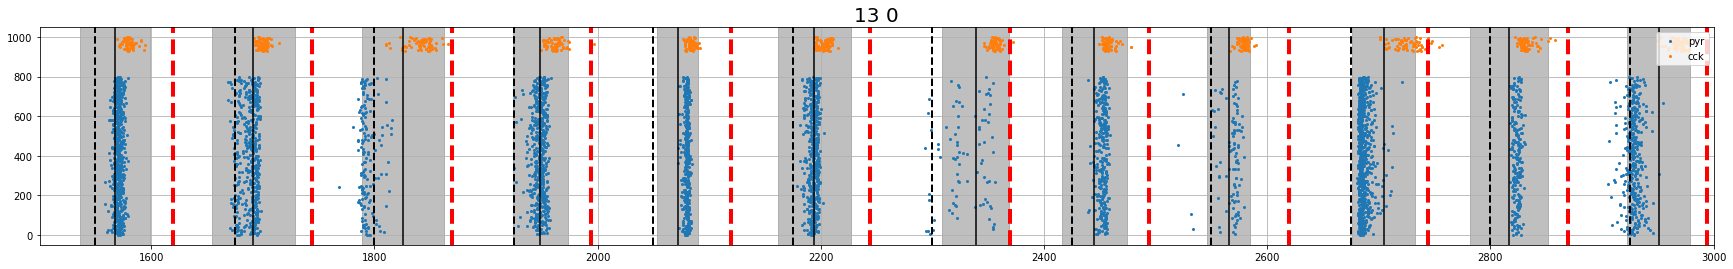

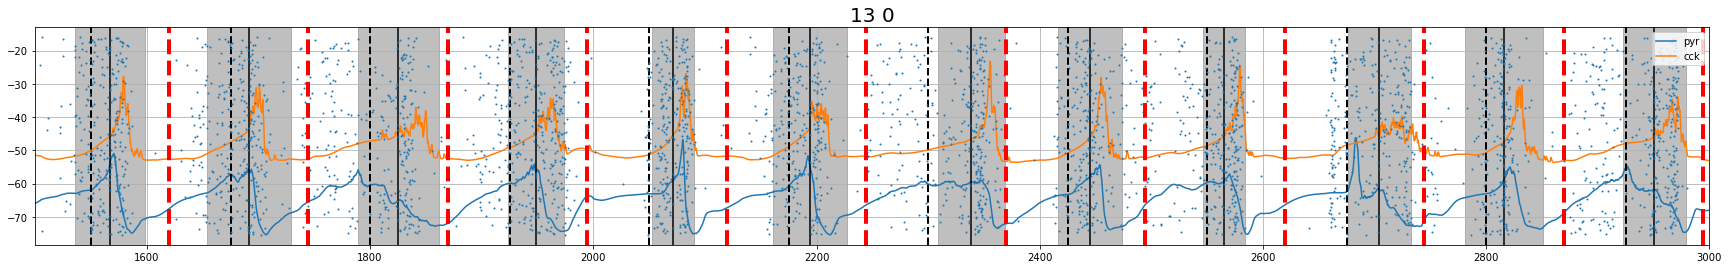

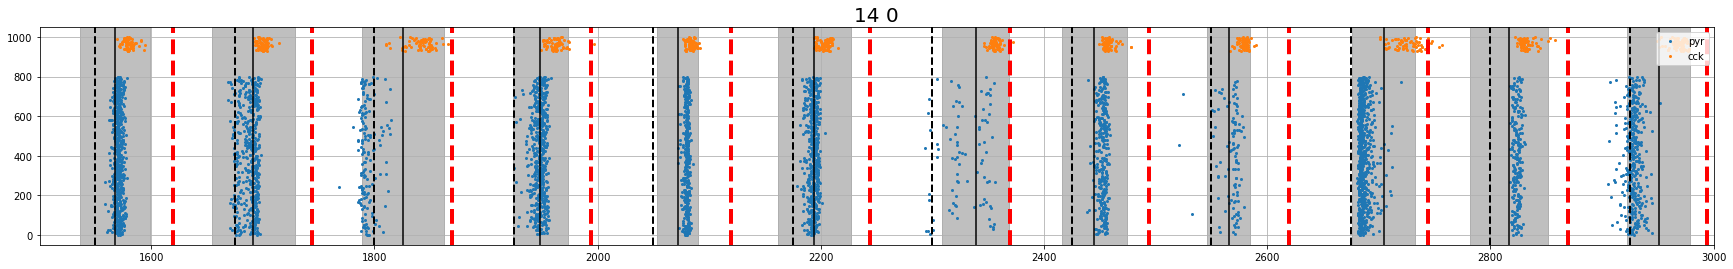

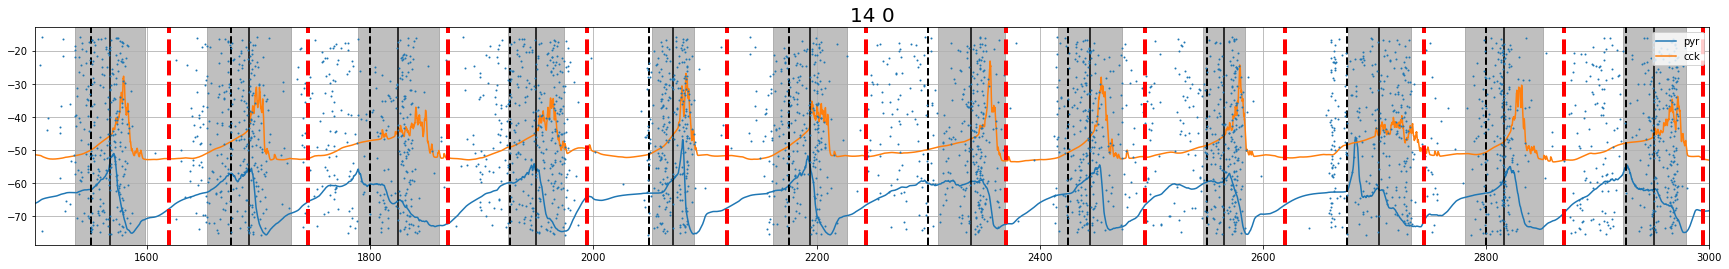

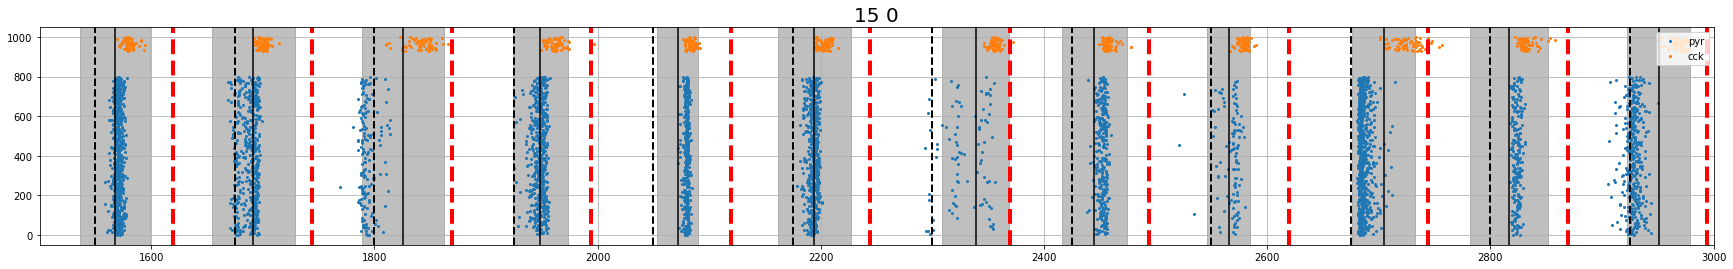

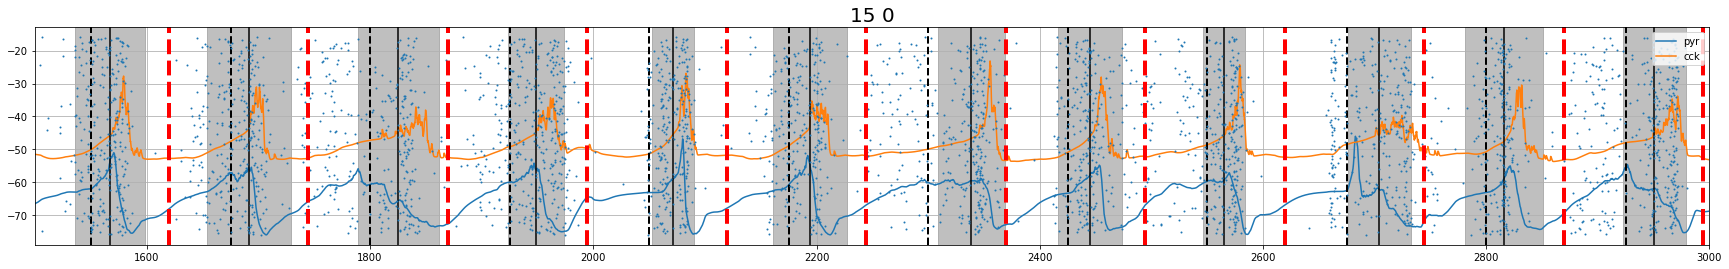

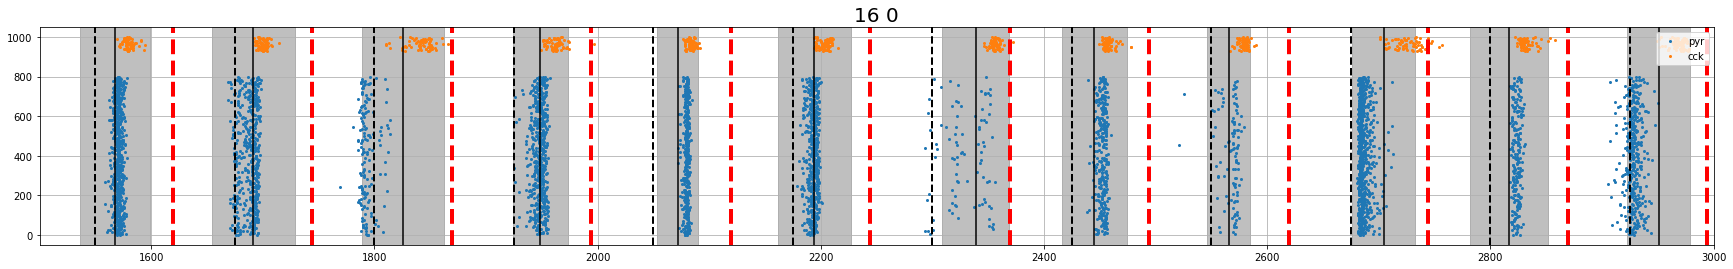

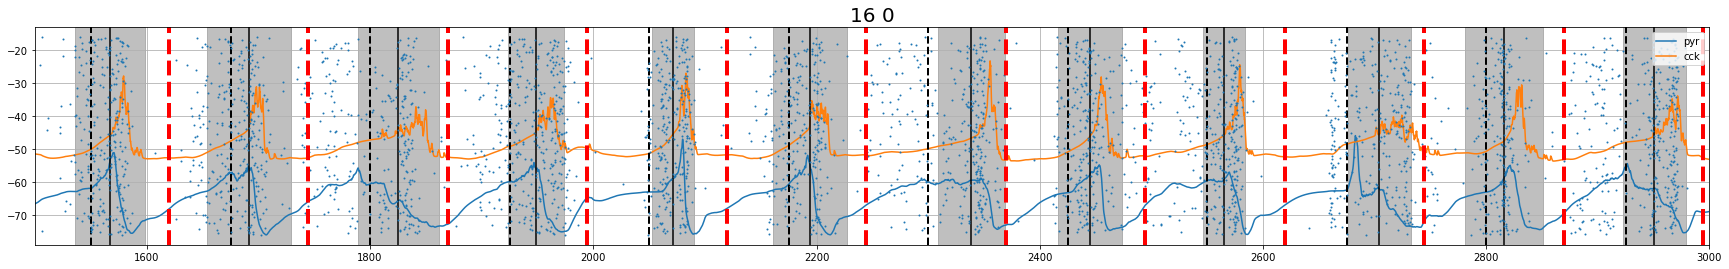

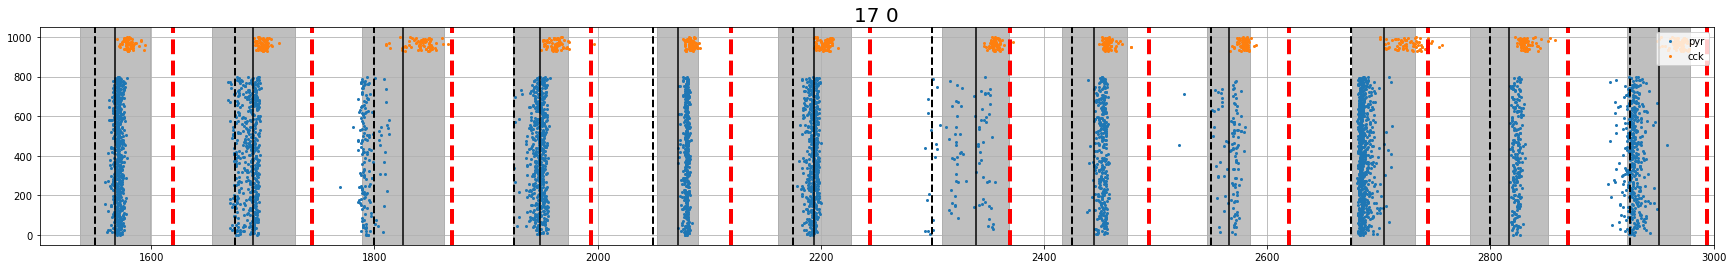

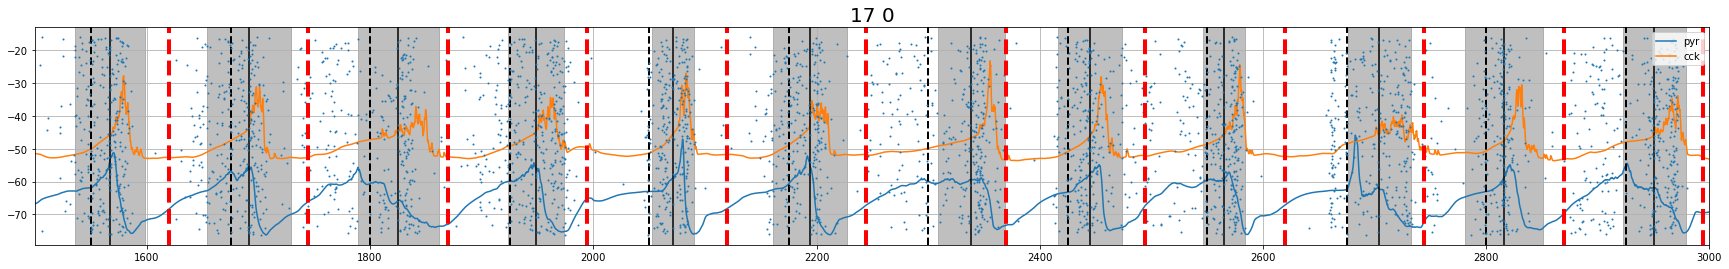

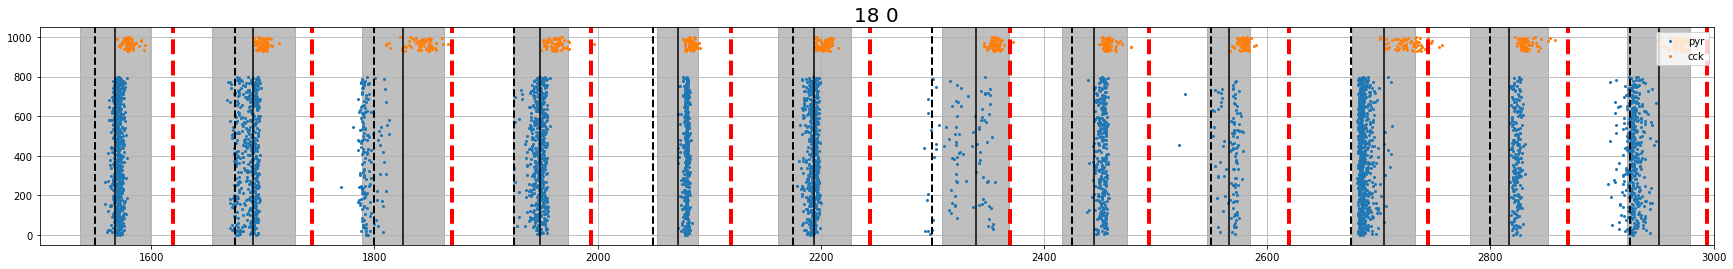

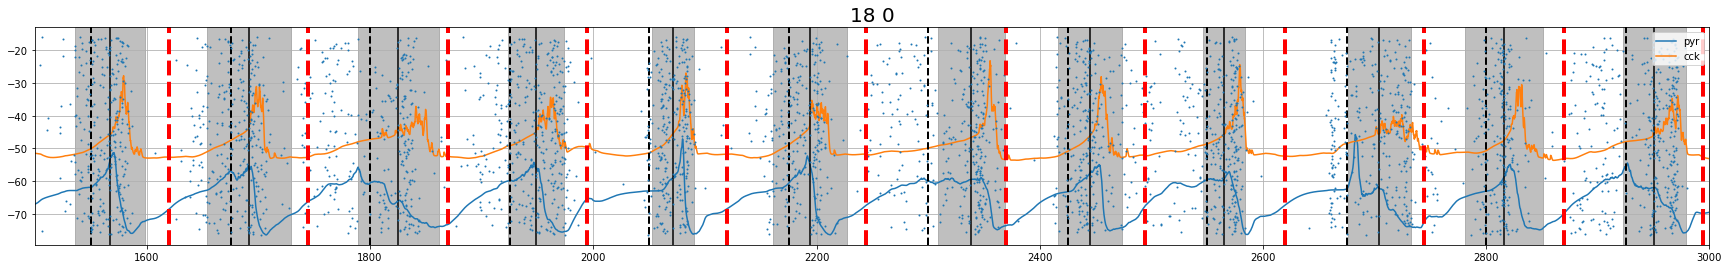

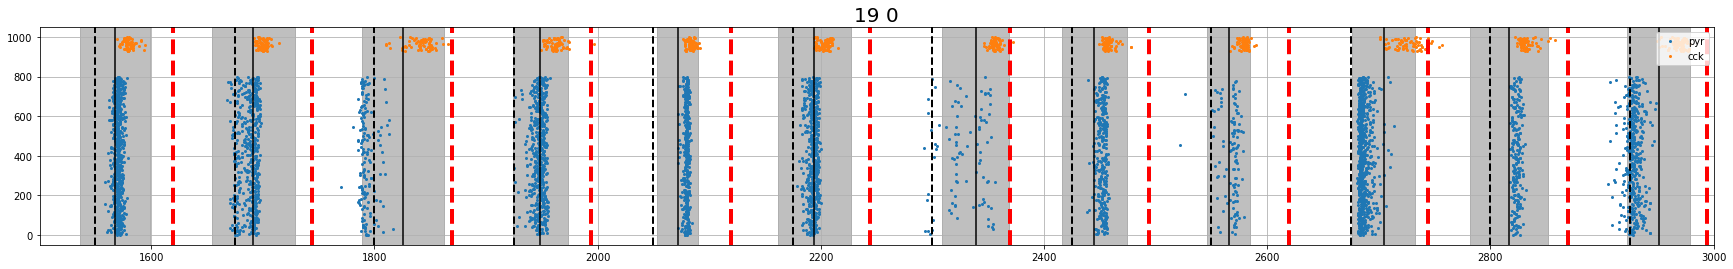

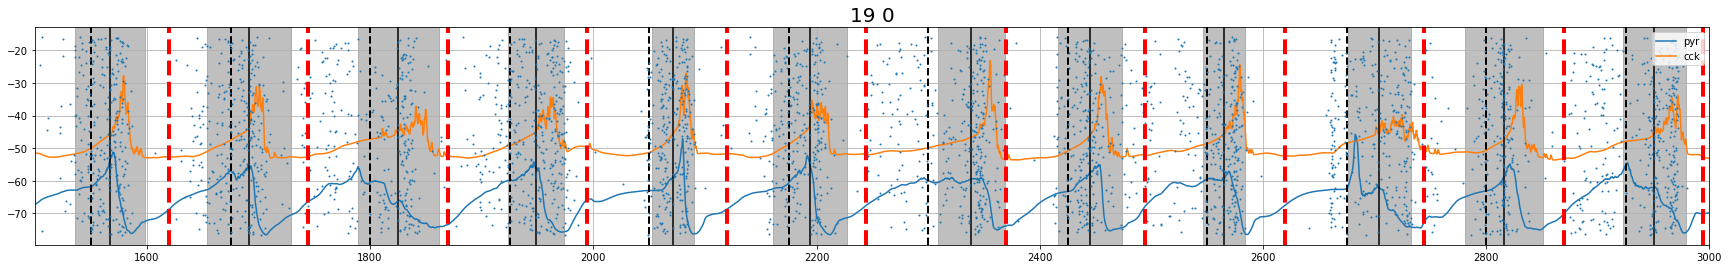

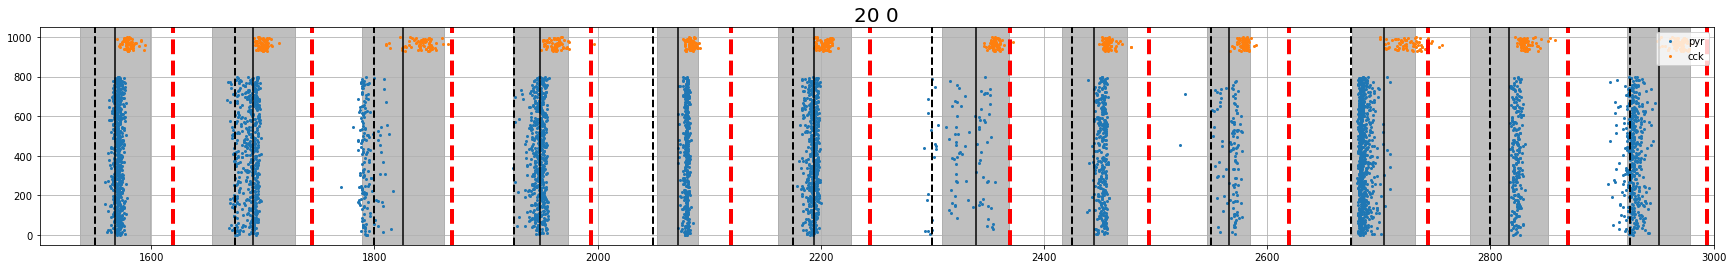

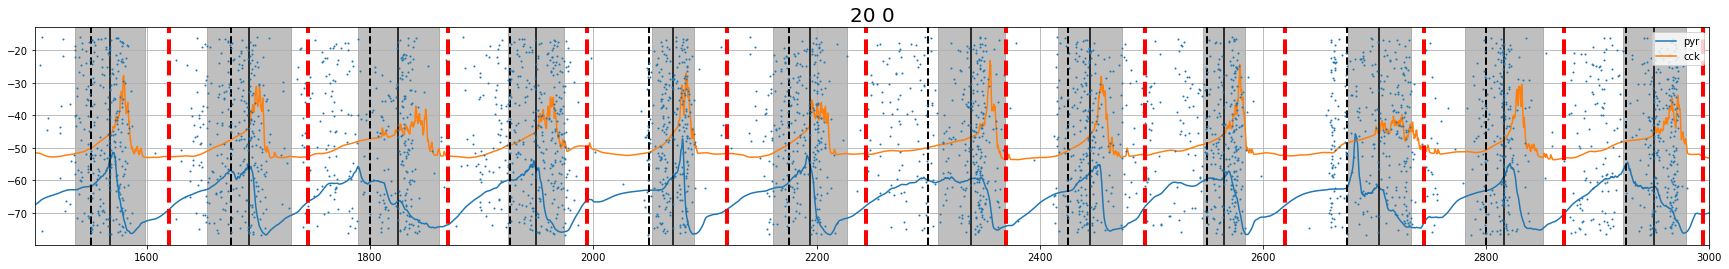

In [8]:
colors = ["tab:blue", "tab:orange","tab:green", "tab:red"]
colors_external_inputs = ["tab:red", "tab:orange", "tab:purple","tab:pink"]
time = np.linspace(0, runtime, len(volt_mean["cck"][0]))

tauseq = np.linspace(0.05,20,21)
for i in range(n):
    for k in range(1):
        #try:
        plt.figure(figsize=(30,4))
        for ii, cell in enumerate(["pyr","cck"]): 
            plt.plot(spikes[cell][i][k], id_spikes[cell][i][k],'o', markersize=2,label=cell,color=colors[ii])
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.title( str(i)+" "+str(k),fontsize=20)

        key = "ec3_360"
        for yh in external_inputs_times[key]:
            plt.axvline(yh,color="black",linewidth=2, linestyle="--")
        key = "pyr_ca3"
        #for yh in external_inputs_times[key]:
        #    plt.axvline(yh,color="black",linewidth=2)
        for h, dh in zip(hpyr_mean, hpyr_std):
            plt.axvline(h, color="black")
            plt.axvspan(h-dh, h+dh, alpha=0.5, color="gray")
            
        for yh in theoretical_center_of_ca1_pyr: 
            plt.axvline(yh, color='red', linewidth=4, linestyle="--")

        plt.xlim([1500,3000])
        
        plt.figure(figsize=(30,4))
        vmin, vmax = [],[]
        for ii, cell in enumerate(["pyr","cck"]): 
            plt.plot(time, volt[cell][i][k],label=cell,color=colors[ii])
            vmin.append( np.min(volt[cell][i][k]) )
            vmax.append( np.max(volt[cell][i][k]) )
        
        vmin = np.min(vmin)
        vmax = np.max(vmax)
        dv = vmax-vmin
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.title( str(i)+" "+str(k),fontsize=20)
        
        key = "ec3_360"
        for yh in external_inputs_times[key]:
            plt.axvline(yh,color="black",linewidth=2, linestyle="--")
            
        key = "pyr_ca3"
        #for yh in external_inputs_times[key]:
        #    plt.axvline(yh,color="black",linewidth=2)
        for h, dh in zip(hpyr_mean, hpyr_std):
            plt.axvline(h, color="black")
            plt.axvspan(h-dh, h+dh, alpha=0.5, color="gray")
            
        x,y = external_inputs_pyr_ca3["tvec"], external_inputs_pyr_ca3["idvec"]
        y = (y-y.min())/(y-y.min()).max()*dv+vmin
        plt.plot(x,y,'o', markersize=1) 

        for yh in theoretical_center_of_ca1_pyr: 
            plt.axvline(yh, color='red', linewidth=4, linestyle="--")
        
        plt.xlim([1500,3000])
        #except:
        #    continue

Text(0, 0.5, 'Delay [ms]')

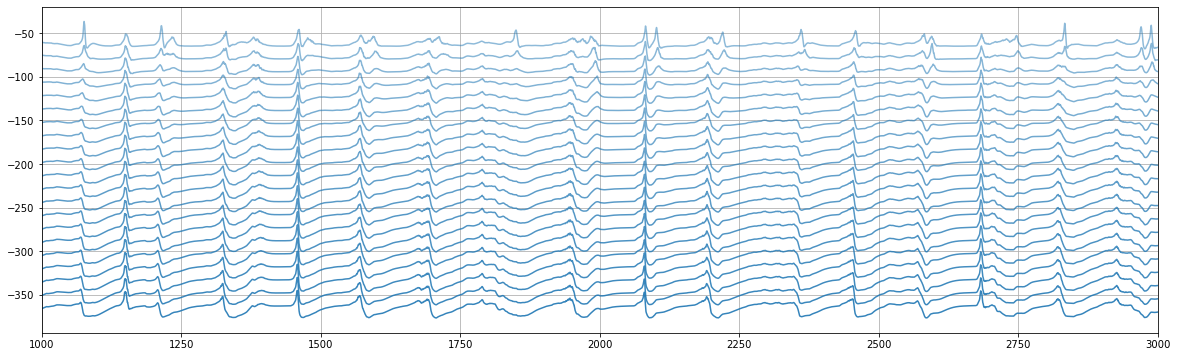

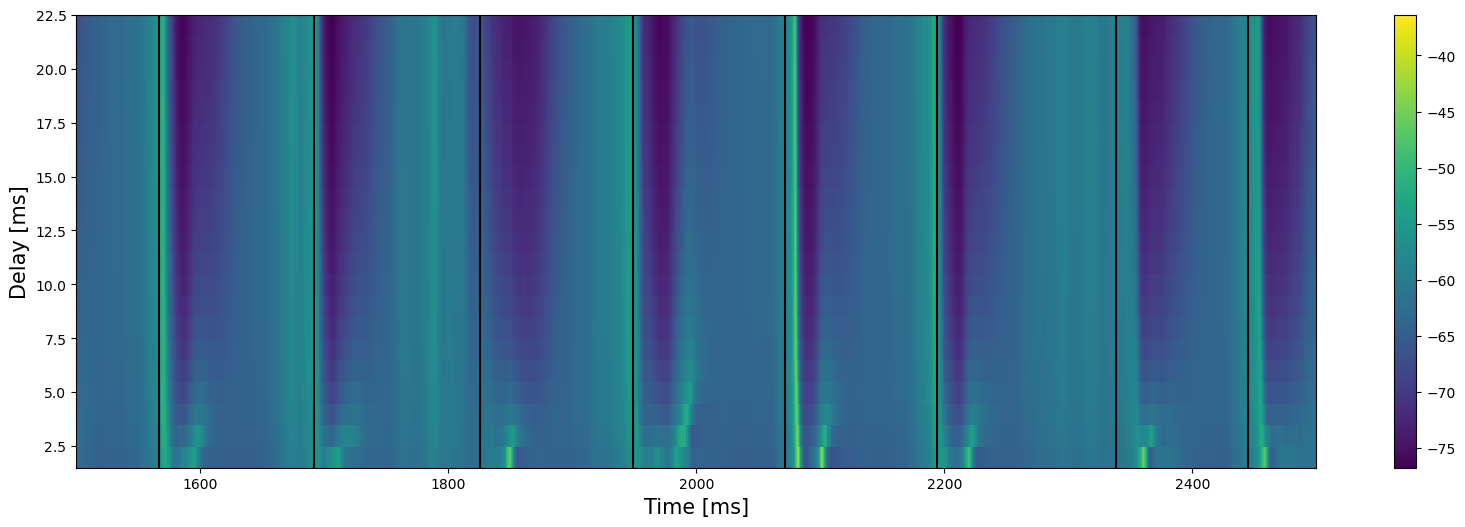

In [9]:
plt.figure(figsize=(20,6))
for i in range(n): 
    plt.plot(time, -15*i+volt["pyr"][i][0],label=cell, color="tab:blue", alpha=0.5+0.02*i)
plt.xlim([1000,3000])
plt.grid(True)

vmap = [] 
for i in range(n):
    vmap.append( volt["pyr"][i][0] )

vmap = np.array(vmap)
plt.figure(figsize=(20,6),dpi=100)
plt.pcolormesh(time, np.arange(2,23,1),vmap,shading="auto" )
for h, dh in zip(hpyr_mean, hpyr_std):
    plt.axvline(h, color="black")
plt.xlim([1500,2500])
plt.colorbar()
plt.xlabel("Time [ms]",fontsize=15)
plt.ylabel("Delay [ms]",fontsize=15)

In [10]:
np.arange(2,23,1)[15]

17

# Distribution of spikes:

In [11]:
binsize = 5 
time_binned = np.arange(0,runtime,binsize)
nbins = len(time_binned)

rate_cycles = dict.fromkeys(["pyr","cck"])
rate_mean = dict.fromkeys(["pyr,cck"])
rate_sem = dict.fromkeys(["pyr,cck"])
ncycles = int((runtime-50)/125)

t0=50
for cell in ["pyr","cck"]:
    rate_mean[cell]   = [ [] for k in range(n) ]
    rate_sem[cell]    = [ [] for k in range(n) ]
    rate_cycles[cell] = [ [] for k in range(n) ]
    for i in range(n):

        y, x = np.histogram(spikes[cell][i][0],bins=time_binned)
        x = x[1:]-np.diff(x)[0]/2

        rate = []
        for l in range(ncycles-1):
            t1 = t0+l*125 
            t2 = t0+(l+1)*125
            rate.append(y[(x>=t1) & (x<t2)])
        
        rate = np.array(rate)
        rate_cycles[cell][i] = np.concatenate(rate)
        rate_mean[cell][i] = np.mean(rate[2:-1],axis=0)
        rate_sem[cell][i]  = np.std(rate[2:-1],axis=0)/np.sqrt(ncycles-3)
    
    rate_mean[cell] = np.array(rate_mean[cell]) 
    rate_sem[cell]  = np.array(rate_sem[cell])

TypeError: Dimensions of C (21, 750) are incompatible with X (800) and/or Y (21); see help(pcolormesh)

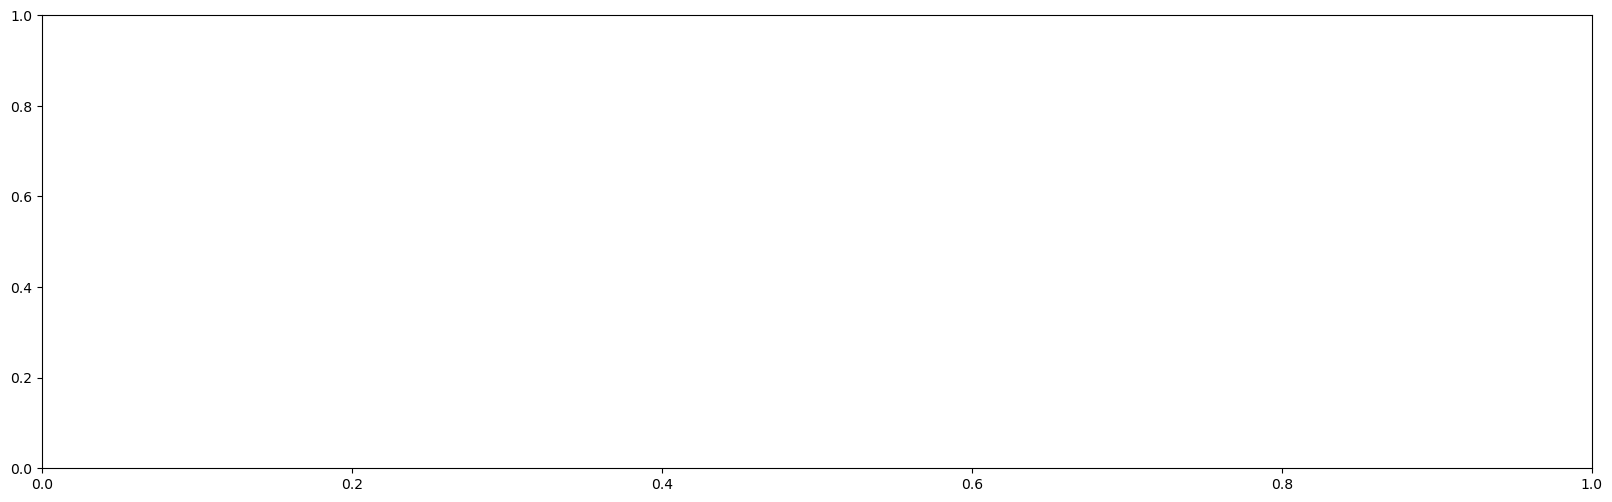

In [12]:
rate_cycles["pyr"] = np.array( rate_cycles["pyr"])
rate_cycles["cck"] = np.array( rate_cycles["cck"])

plt.figure(figsize=(20,6),dpi=100)
plt.pcolormesh(time_binned, np.arange(2,23,1), rate_cycles["pyr"],shading="auto" )
#for h, dh in zip(hpyr_mean, hpyr_std):
#Ç    plt.axvline(h, color="black")
#plt.xlim([1500,2500])
plt.colorbar()
plt.xlabel("Time [ms]",fontsize=15)
plt.ylabel("Delay [ms]",fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5),dpi=100) 
phase = np.linspace(0,360,25)
for i,(r,rs) in enumerate( zip(rate_mean["pyr"], rate_sem["pyr"])):
    ax.plot(phase,r,alpha=0.05*i, color="tab:blue")
    # ax.fill_between(phase, r-rs, r+rs, alpha=0.05*i, color="tab:blue")
ax.grid(True)
ax.set_ylabel("# spikes pyr", color="tab:blue")
ax.set_xlabel("Theta phase")
ax2 = ax.twinx()
ax2.plot(phase, rate_mean["cck"][0], color="tab:orange")
# ax2.fill_between(phase, rate_mean["cck"][0]-rate_sem["cck"][0], rate_mean["cck"][0]+rate_sem["cck"][0], color="tab:orange", alpha=0.5)

ax2.set_ylabel("# spikes cck", color="tab:orange")

In [ ]:
plt.pcolormesh( rate_mean["cck"])
plt.figure()
plt.pcolormesh( rate_mean["pyr"])

In [ ]:
plot_volts = False

if plot_volts: 
    
    colors = ["tab:blue", "tab:orange","tab:green", "tab:red"]
    colors_external_inputs = ["tab:red", "tab:orange", "tab:purple","tab:pink"]
    tauseq = np.linspace(0.05,20,21)

    t1, t2 = 2000,3000
    runtime = 3000
    time = np.linspace(0, runtime, len(volt_mean["cck"][0]))
    window_time = (time >= t1) & (time<t2)
    for i in range(n):
        for k in range(1):
            #try:
            fig, ax = plt.subplots( figsize=(30,4) )
            for ii, cell in enumerate(["pyr","bas","olm", "cck"]): 
                #cell = "cck"
                ax.plot(time[window_time], volt_mean[cell][i][window_time])# label=cell,color=colors[ii]) 
                #cell = "bas"
                #plt.plot(time[window_time], volt_mean[cell][i][window_time])# label=cell,color=colors[ii]) 

                y1 = (volt_mean[cell][i] + volt_sem[cell][i])[window_time]
                y2 = (volt_mean[cell][i] - volt_sem[cell][i])[window_time]
                ax.fill_between(time[window_time], y1,y2,alpha=0.5)
            ax.grid(True)
            #plt.legend(loc='upper right')
            ax.set_title( str(i)+" "+str(k),fontsize=20)
            ax2 = ax.twinx()
            # ax2.plot( external_inputs["ec3_360"]["tvec"], external_inputs["ec3_360"]["idvec"],'o',markersize=1 )
            # ax2.plot( spikes["cck"]["tvec"][i][0], spikes["cck"]["idvec"][i][0],'o', markersize=1)
            ax2.plot( spikes["cck"][i][0], id_spikes["cck"][i][0],'o',markersize=2)

            key = "ec3_360"
            for yh in external_inputs_times[key]:
                plt.axvline(yh,color="black",linewidth=2, linestyle="--")

            key = "pyr_ca3"
            for yh in external_inputs_times[key]:
                plt.axvline(yh,color="black",linewidth=2)

            for yh in theoretical_center_of_ca1_pyr: 
                plt.axvline(yh, color='red', linewidth=4, linestyle="--")

            ax.set_xlim([t1,t2])
            fig, ax = plt.subplots( figsize=(30,4) )
            cell = "cck"
            ax.plot(time[window_time], volt_mean[cell][i][window_time], color="tab:red")# label=cell,color=colors[ii]) 
            y1 = (volt_mean[cell][i] + volt_sem[cell][i])[window_time]
            y2 = (volt_mean[cell][i] - volt_sem[cell][i])[window_time]
            ax.fill_between(time[window_time], y1,y2,alpha=0.5, color="tab:red") 
            cell = "pyr"
            ax2 = ax.twinx()
            ax2.plot(time[window_time], volt_mean[cell][i][window_time])# label=cell,color=colors[ii]) 
            y1 = (volt_mean[cell][i] + volt_sem[cell][i])[window_time]
            y2 = (volt_mean[cell][i] - volt_sem[cell][i])[window_time]
            ax2.fill_between(time[window_time], y1,y2,alpha=0.5) 
            ax.grid(True)
            for yh in theoretical_center_of_ca1_pyr: 
                ax.axvline(yh, color='red', linewidth=4, linestyle="--")
            # key = "sep_180"
            # for yh in external_inputs_times[key]:
            #    plt.axvline(yh,color="green",linewidth=2)

            # for yh in theoretical_center_of_ca1_pyr: 
            #    plt.axvline(yh, color='red', linewidth=4, linestyle="--")
            ax.set_xlim([t1,t2])

In [ ]:
phase_plots = False
if phase_plots:
    
    phase_ec3 = np.zeros( len(time ))
    ec3_times = [50]
    while ec3_times[-1]<= runtime-125: 
        ec3_times.append( ec3_times[-1]+125)
    
    for t1, t2 in zip( ec3_times[:-1], ec3_times[1:]): 
        nn = int((t2-t1)/dt + 1 )
        i1, i2 = int(t1/dt+1), int(t2/dt+1)
        phase_ec3[i1:i2+1] = np.linspace(0,2*np.pi, nn)
    
    
    ncells = {}
    ncells["pyr"] = 800
    ncells["bas"] = 100
    ncells["olm"] = 30
    ncells["cck"] = 70

    phase_mean = dict.fromkeys(cells)
    phase_std  = dict.fromkeys(cells)
    phase_sem  = dict.fromkeys(cells)
    phase_peak = dict.fromkeys(cells)

    for i in range(n): 
        for cell in cells: 
            phase_mean[cell] = [ [] for i in range(n) ]
            phase_std[cell]  = [ [] for i in range(n) ]
            phase_sem[cell]  = [ [] for i in range(n) ]
            phase_peak[cell] = np.zeros(n)

    for cell in cells: 
        for i in range(n):
            xlist, ylist = spikes[cell][i], id_spikes[cell][i]
            phiseq, phase_mean[cell][i], phase_std[cell][i], phase_sem[cell][i], phase_peak[cell][i] = get_spiking_phase_distribution(xlist,ylist,phase_reference=phase_ec3, simulation_time=runtime)
           

    plt.plot(np.arange(n), phase_peak["pyr"],'o')
    plt.axhline(90, linestyle="--")
    plt.axhline(180, linestyle="--")
    plt.grid(True)
    plt.xlabel('# scan')
    plt.ylabel("pyr phase peak [deg]")
    #plt.plot(np.arange(n), phase_peak["bas"],'o')
    #plt.plot(np.arange(n), phase_peak["olm"])

    ip = 16
    plt.figure() 
    plt.step(phiseq, phase_mean["pyr"][ip],where="mid")
    plt.fill_between(phiseq, np.zeros(len(phiseq)), phase_mean["pyr"][ip],alpha=0.4, step="mid")
    plt.grid(True)
    plt.xlabel("Theta phase [deg]")
    plt.ylabel("Spikes")
    plt.axvline(phase_peak["pyr"][ip],color="tab:red")
    plt.axvline(phase_peak["pyr"][ip]+360,color="tab:red")

In [ ]:
conn = np.arange(25,130,5)
len(conn)

In [ ]:
for ii, cell in enumerate(["pyr","cck"]): 
    plt.plot(time, volt[cell][i][k],label=cell,color=colors[ii])
plt.figure() 



In [ ]:
for ii, cell in enumerate(["pyr","cck"]): 
    plt.plot(time, volt[cell][i][k],label=cell,color=colors[ii])
    vmin.append( np.min(volt[cell][i][k]) )
    vmax.append( np.max(volt[cell][i][k]) )

vmin = np.min(vmin)
vmax = np.max(vmax)
dv = vmax-vmin
plt.grid(True)
plt.legend(loc='upper right')
plt.title( str(i)+" "+str(k),fontsize=20)

key = "ec3_360"
for yh in external_inputs_times[key]:
    plt.axvline(yh,color="black",linewidth=2, linestyle="--")

key = "pyr_ca3"
#for yh in external_inputs_times[key]:
#    plt.axvline(yh,color="black",linewidth=2)
for h, dh in zip(hpyr_mean, hpyr_std):
    plt.axvline(h, color="black")
    plt.axvspan(h-dh, h+dh, alpha=0.5, color="gray")

x,y = external_inputs_pyr_ca3["tvec"], external_inputs_pyr_ca3["idvec"]
y = (y-y.min())/(y-y.min()).max()*dv+vmin
plt.plot(x,y,'o', markersize=1) 

for yh in theoretical_center_of_ca1_pyr: 
    plt.axvline(yh, color='red', linewidth=4, linestyle="--")



In [ ]:
plt.figure(figsize=(30,4))
for ii, cell in enumerate(["pyr","cck"]): 
    plt.plot(spikes[cell][i][k], id_spikes[cell][i][k],'o', markersize=2,label=cell,color=colors[ii])
plt.grid(True)
plt.legend(loc='upper right')
plt.title( str(i)+" "+str(k),fontsize=20)